In [4]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.constants import k as kB, R, h, hbar
from scipy.integrate import quad
from scipy.optimize import curve_fit

In [5]:
mp_key = "0TSH4JPmYApoWkybWbmreInYgdHzp5GT"
mp_id = "mp-29678"

In [7]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Chaleur spécifique

La chaleur spécifique à volume constant représente la quantité de chaleur qu'il faut apporter pour augmenter la température d'un  solide de 1K pour un volume constant.

Einstein et Debye ont développé chacun un modèle théorique pour exprimer l'évoluion de $C_v$ d'un solide cristallin harmonique en fonction de la température.

Einstein a supposé que chaque atome du crystal était un oscillateur harmonique possédant un pulsation $\omega_0$. La loi de $C_v$ peut être déterminée grâce à la physique statistique et nous donne pour ce modèle ce résultat:

\begin{equation}
    C_v = 3N_{at}R(\frac{\hbar\omega_E}{k_BT})^2\frac{\exp{(\frac{\hbar\omega_E}{k_BT})}}{(\exp{(\frac{\hbar\omega_E}{k_BT})}-1)^2}
\end{equation}

et la température d'Einstein qui est proche de la température de fusion du solide:

\begin{equation}
    \Theta_E = \frac{\hbar\omega_E}{k_B}
\end{equation}


In [8]:
temperatures = np.arange(10,1000,5)
R = 8.314
nat = len(prim_struc)
ph_cvreal = np.array([ph_dos.cv(T) for T in temperatures])/(3*nat*R)


In [9]:
def Cv_Einstein(T, theta_e):
    return (theta_e/T)**2* np.exp(theta_e/T)/(np.exp(theta_e/T)-1) ** 2
T = temperatures
popt_einstein= curve_fit(Cv_Einstein, T, ph_cvreal)[0]

def mse_Einstein(theta_e):
    cv_d = np.array([Cv_Einstein(T, theta_e) for T in temperatures])
    return np.mean((ph_cvreal - cv_d)**2)

opt_e = minimize_scalar(mse_Einstein, bounds=(10, 1000), method="bounded")

theta_e_opt = opt_e.x
cv_einstein = np.ones(len(temperatures))
for i in range(len(cv_einstein)):
    cv_einstein[i] = Cv_Einstein(temperatures[i], theta_e_opt)

Le modèle de Debye suppose que toutes les fréquences ont la même dispersion linéaire : \omega = vq où v est la vitesse de phase et q le vecteur d'onde du phonon.

On obtient avec cette loi:

\begin{equation}
    C_v = 9N_{at}R(\frac{T}{\Theta_D})^3\int_0^{{\frac{\Theta_D}{T}}} \frac{x^4\exp{(x)}}{(\exp{(x)}-1)^2}\,dx 
\end{equation}

La température de Debye est :

\begin{equation}
    \Theta_D = \frac{\hbar\omega_D}{k_B}
\end{equation}

Elle est donc liée à la pulsation maximale présente dans le solide.

In [10]:
volume = prim_struc.volume * 1e-30
q_debye = (6 * np.pi**2 / volume) ** (1 / 3)

def Cv_Debye(T, theta_d):
    x = theta_d / T
    
    return 3*(T / theta_d)**3 *np.array([quad(lambda x: x**4 * np.exp(x) / (np.exp(x) - 1) ** 2, 1e-7, theta_d / t)[0] for t in T])

In [11]:
# Pour Debye
def mse_debye(theta_d):
    cv_d = np.array([cv_debye(T, theta_d) for T in temperatures])
    return np.mean((ph_cvreal - cv_d)**2)

# opt_d = minimize_scalar(mse_debye, bounds=(10, 1000), method="bounded")
popt_debye= curve_fit(Cv_Debye, T, ph_cvreal)[0]

# theta_d_opt = opt_d.x

cv_debye = np.ones(len(temperatures))
for i in range(len(cv_debye)):
    cv_debye = Cv_Debye(temperatures, popt_debye)

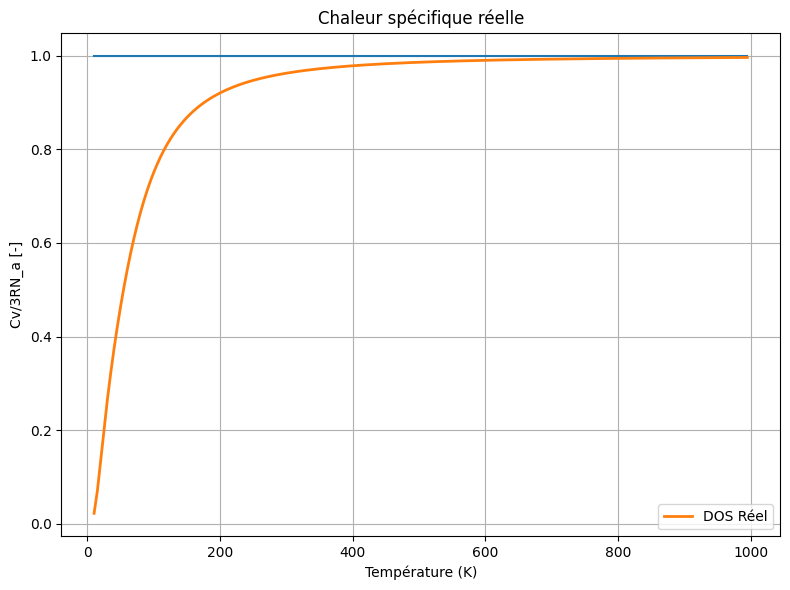

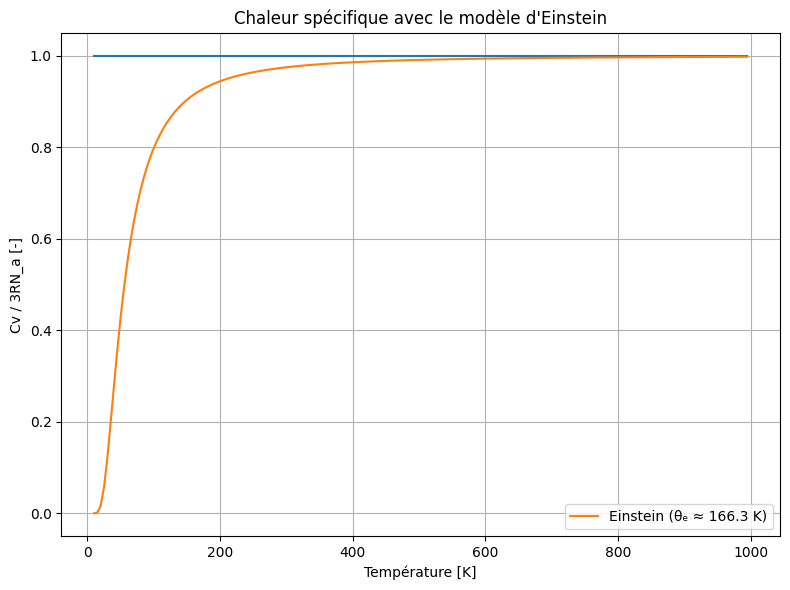

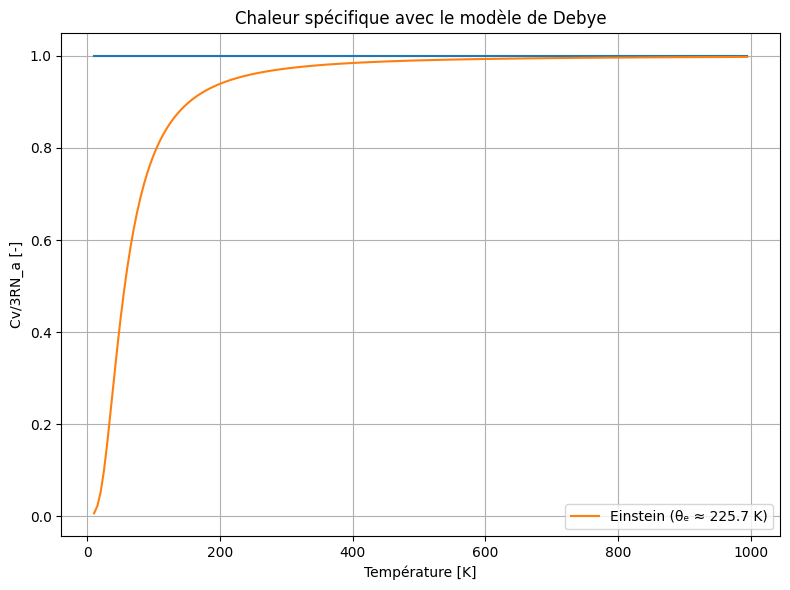

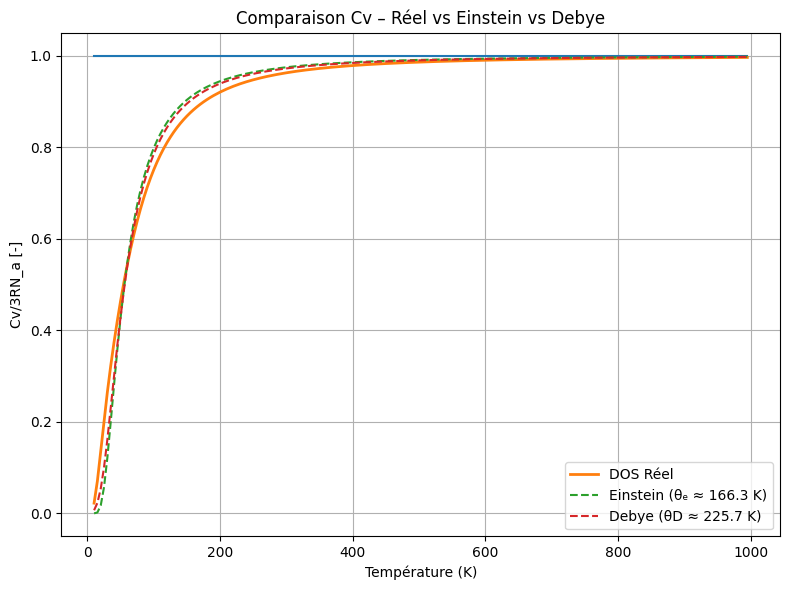

In [64]:
plt.figure(figsize=(8,6))
plt.plot(temperatures, np.ones(len(temperatures)))
plt.plot(temperatures, ph_cvreal, label="DOS Réel", linewidth=2)
plt.xlabel("Température (K)")
plt.ylabel('Cv/3RN_a [-]')
plt.title("Chaleur spécifique réelle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



plt.figure(figsize=(8,6))
plt.plot(temperatures, np.ones(len(temperatures)))
plt.plot(temperatures, cv_einstein, label=f"Einstein (θₑ ≈ {theta_e_opt:.1f} K)")
plt.xlabel("Température [K]")
plt.ylabel("Cv / 3RN_a [-]")
plt.title("Chaleur spécifique avec le modèle d'Einstein")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(temperatures, np.ones(len(temperatures)))
plt.plot(temperatures, cv_debye, label=f"Einstein (θₑ ≈ {popt_debye[0]:.1f} K)")
plt.xlabel("Température [K]")
plt.ylabel('Cv/3RN_a [-]')
plt.title("Chaleur spécifique avec le modèle de Debye")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,6))
plt.plot(temperatures, np.ones(len(temperatures)))
plt.plot(temperatures, ph_cvreal, label="DOS Réel", linewidth=2)
plt.plot(temperatures, cv_einstein, '--', label=f"Einstein (θₑ ≈ {theta_e_opt:.1f} K)")
plt.plot(temperatures, cv_debye, '--', label=f"Debye (θD ≈ {popt_debye[0]:.1f} K)")
plt.xlabel("Température (K)")
plt.ylabel('Cv/3RN_a [-]')
plt.title("Comparaison Cv – Réel vs Einstein vs Debye")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
print("La température d'Einstein vaut", opt_e.x, "[K]")
print("La température de Debye vaut", popt_debye[0], "[K]")

La température d'Einstein vaut 166.27546229831293 [K]
La température de Debye vaut 225.72300403141708 [K]


Nous pouvons voir que pour le $A_gB_iS_2$, les chaleurs spécifiques prédites par le modèle de Debye et d'Einstein sont proches du la chaleur spécifique expérimentale. On peut cependant remarquer que le modèle de Debye est légèrement mieux que celui d'Einstein car la dispersion linéaire est une hypothèse plus correcte qu'une fréquence constante.

# Densité d'états de phonons

La fréquence d'Einstein vaut 3.4646184774651605 [Thz].
La fréquence d'Einstein vaut 4.703304262375972e+24 [Thz].


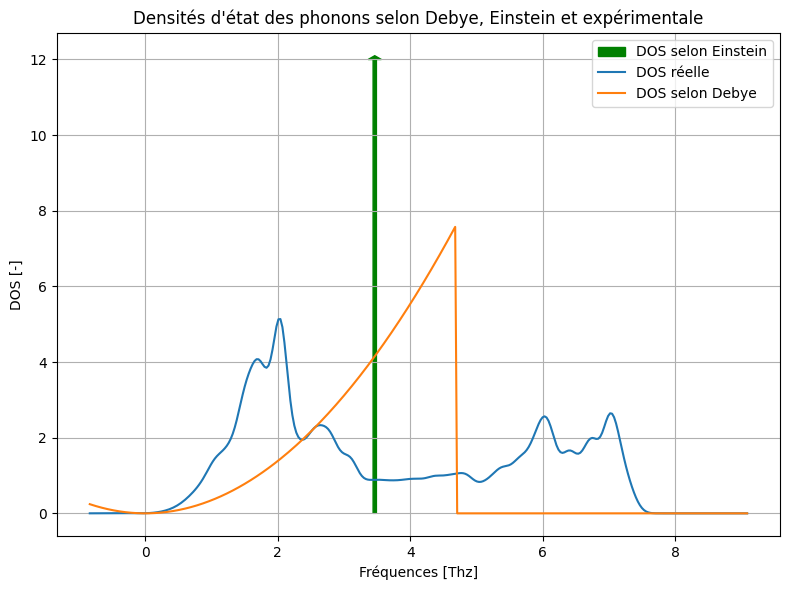

In [61]:
frequence_Einstein = theta_e_opt*kB/(2*np.pi*hbar*1e12)
print("La fréquence d'Einstein vaut", frequence_Einstein, "[Thz].")
frequence_Debye = (kB*popt_debye/(2*np.pi*hbar*10**-12))[0]
print("La fréquence d'Einstein vaut", frequence_Debye, "[Thz].")
v = 2*np.pi*frequence_Debye/q_debye

frequence_Debye = (kB*popt_debye[0]/(hbar*2*np.pi))*10**-12

def Densite_Debye(frequences):
    DOS = np.zeros(len(frequences))
    for i in range(len(frequences)):
        if(frequences[i]<frequence_Debye):
            DOS[i] = (3*nat*volume*(frequences[i])**2*q_debye**3)/(2*(np.pi**2)*frequence_Debye**3)
    return DOS
frequencies = ph_dos.frequencies
density = ph_dos.densities


plt.figure(figsize=(8,6))
plt.arrow(frequence_Einstein, 0, 0, 3*nat, width=0.05, head_width=0.2, head_length=0.1, fc='green', ec='green', label = "DOS selon Einstein")
plt.plot(frequencies, density, label="DOS réelle")
plt.plot(frequencies, Densite_Debye(frequencies), label="DOS selon Debye")
plt.xlabel("Fréquences [Thz]")
plt.ylabel('DOS [-]')
plt.title("Densités d'état des phonons selon Debye, Einstein et expérimentale")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



La densité d'état des phonons du modèle d'Einstein est sans surprise un delta de Dirac car une seule fréquence est présente dans le cristal et est donné par :

\begin{equation}
    g_E(\omega) = 3N_{at}\delta(\omega-\omega_E)
\end{equation}

Le modèle de Debye prédit comme densité d'état des phonons:


\begin{equation}
    g_D(\omega) = \frac{3N_{at}V\omega^2}{2\pi^2v^3} ,  \omega < \omega_D
\end{equation}

\begin{equation}
    g_D(\omega) = 0 ,  \omega > \omega_D
\end{equation}

Les 2 fonctions sont de grossières approximations étant donné que les modèles ne tiennent pas comptent des vraies relations de dispersion.

